## 2.1 행렬 분해의 기본 원리
추천 시스템에서 사용되는 행렬 분해의 개념과 필요성 설명.


In [ ]:
!pip install datasets==2.20.0

In [11]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
data = load_dataset("ashraq/movielens_ratings")["train"].shuffle(seed=10).select(range(200000))

In [ ]:
movielens_df = pd.DataFrame(data)
movielens_df = movielens_df[["user_id", "movie_id", "rating"]]

user_ids = movielens_df["user_id"].unique()
user_id_map = {id: index for index, id in enumerate(user_ids)}
movie_ids = movielens_df["movie_id"].unique()
movie_id_map = {id: index for index, id in enumerate(movie_ids)}

movielens_df["user_id"] = movielens_df["user_id"].map(user_id_map)
movielens_df["movie_id"] = movielens_df["movie_id"].map(movie_id_map)

train_data, test_data = train_test_split(movielens_df, test_size=0.2, random_state=10)

In [ ]:
num_users = len(user_ids)
num_movies = len(movie_ids)
num_features = 10

# 사용자와 영화 각각에 대해 10차원의 잠재 요인 벡터(Latent Vector)를 무작위로 초기화
# np.random.normal(0, .1, size) = 평균이 0이고, 표준편차가 0.1인 정규분포에서 랜덤하게 수를 뽑아 (사용자의 수 or 영화 수, 특징 수) 배열을 만든다!
# 왜 정규분포로 Latent Factor 초기화해?
# 대부분의 값이 0근처에 시작하므로 너무 크거나 작은 값이 없다 -> 안정적
# 초기 Latent Vector 값은 랜덤이지만, 오차값이 줄어드는 방향으로 학습
user_features = np.random.normal(0, .1, (num_users, num_features))
movie_features = np.random.normal(0, .1, (num_movies, num_features))

learning_rate = 0.01
# L2 Norm 사용 - 파라미터에 제곱합 사용, 파라미터의 크기가 너무 치솟는 현상 방지, 과적합 방지
# L1 Norm은 뭐야? - 파라미터에 절대값의 합 사용, 일부 파라미터 값이 0 -> 파라미터 비활성화 -> 모델에 희소성 부여, 특정 특성 선택하도록 유도
regularization = 0.1
epochs = 20
epoch_rmse: list[float] = []

# User Latent Vector와 Movie Latent Vector의 내적을 통해 예측 평점 계산
# 내적 -> 크기/방향 모두 비교, 평점 예측, 학습 과정 필요, 결과값은 정량적 점수
# 코사인 유사도 -> 크기 비교x/방향만 비교, 학습 과정 필요x, 비슷한 사용자/영화를 찾는데 사용
def predict_rating(user_id: int, movie_id: int) -> float:
    return np.dot(user_features[user_id], movie_features[movie_id])


for epoch in tqdm(range(epochs)):
    squared_errors: list[float] = []

    for _, row in train_data.iterrows():
        user_id = int(row["user_id"])
        movie_id = int(row["movie_id"])
        rating = row["rating"]

        prediction = predict_rating(user_id, movie_id)

        # 실제 평점과 예측 평점 사이의 오차 계산
        error = rating - prediction
        squared_errors.append(error**2)

        # 경사 하강법(Stochastic Gradient Descent)로 벡터 업데이트
        # -> 오차를 줄이도록 User Latent Vector와 Movie Latent Vector 조금씩 수정하기위해 필요
        # regularization은 과적합을 방지하기 위해 사용, 한 쪽의 파라미터에 강력하게 영향을 미치지 않도록.
        # 사용자 벡터 <- 사용자 벡터 + 학습률 x (오차 x 영화 벡터 - 정규화값 x 사용자 벡터)
        # 사용자 벡터 += 업데이트할 방향
        user_features[user_id] += learning_rate * (error * movie_features[movie_id] - regularization * user_features[user_id])
        movie_features[movie_id] += learning_rate * (error * user_features[user_id] - regularization * movie_features[movie_id])

    epoch_rmse.append(np.sqrt(np.mean(squared_errors)))

100%|██████████| 20/20 [03:34<00:00, 10.74s/it]


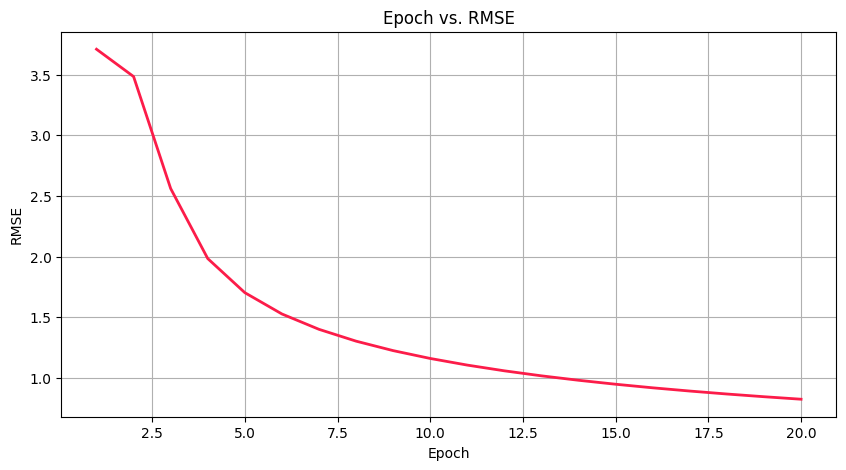

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), epoch_rmse, linewidth=2, color="#fc1c49")
plt.title("Epoch vs. RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

In [ ]:
predictions: list[float] = []
true_ratings: list[float] = []

for _, row in tqdm(test_data.iterrows(), total=test_data.shape[0]):
    user_id = int(row["user_id"])
    movie_id = int(row["movie_id"])
    true_rating = row["rating"]

    predicted_rating = predict_rating(user_id, movie_id)
    predictions.append(round(predicted_rating))
    true_ratings.append(true_rating)

100%|██████████| 40000/40000 [00:02<00:00, 15194.56it/s]


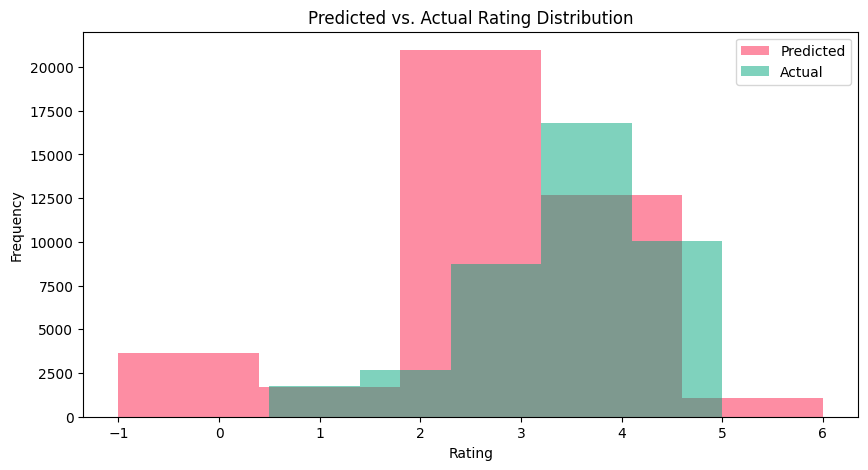

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(predictions, bins=5, alpha=0.5, label="Predicted", color="#fc1c49")
plt.hist(true_ratings, bins=5, alpha=0.5, label="Actual", color="#00a67d")
plt.title("Predicted vs. Actual Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# -1, 0, 6도 예측됨 -> 더 많은 데이터셋 추가 또는 프로세싱 추가 필요

In [ ]:
rmse = np.sqrt(np.mean((np.array(predictions) - np.array(true_ratings))**2))
print(f"RMSE: {rmse}")

RMSE: 1.5732907391833209
